In [2]:
%pip install keras tensorflow scikit-learn pandas numpy matplotlib opencv-python tqdm==2.2.3 seaborn imutils

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Potat\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:

from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
import imutils
import cv2
import os
from PIL import Image
import io
from glob import glob

# No ejecutar
Seccion de conversion de imagen a bordes
---

In [4]:
def drawborders(im):
  im = Image.fromarray(im)
  im = im.convert('RGB')
  arr = np.array(im)
  height = arr.shape[0]
  width = arr.shape[1]
  gray = cv2.cvtColor(arr,cv2.COLOR_BGR2GRAY)
  edged = cv2.Canny(gray, 30, 200)
  cv2.waitKey(0)

  contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.waitKey(0)
  print("Number of Contours found = " + str(len(contours)))
  arr2 = np.zeros((height,width,3), np.uint8)

  im_contour = cv2.drawContours(arr2, contours, -1, (255, 255, 255), 3)

  return arr2

In [67]:
Set = 'Training'
tumor = 'glioma'
name = 'gl'

files = glob(f'C:/Users/Potat/Desktop/WorkSpace/DataScience/dataset_borders/{Set}/{tumor}/*.jpg')
print(len(files))

1283


In [68]:
for i in range(len(files)):

    #cv2.imwrite(f"C:/Users/Potat/Desktop/WorkSpace/DataScience/Borders/{Set}/{tumor}/{name}_cnt{i}.jpg", drawborders(cv2.imread(files[i])))

Number of Contours found = 240
Number of Contours found = 239
Number of Contours found = 171
Number of Contours found = 198
Number of Contours found = 213
Number of Contours found = 298
Number of Contours found = 284
Number of Contours found = 213
Number of Contours found = 223
Number of Contours found = 248
Number of Contours found = 323
Number of Contours found = 188
Number of Contours found = 293
Number of Contours found = 212
Number of Contours found = 177
Number of Contours found = 281
Number of Contours found = 222
Number of Contours found = 219
Number of Contours found = 248
Number of Contours found = 210
Number of Contours found = 187
Number of Contours found = 193
Number of Contours found = 242
Number of Contours found = 141
Number of Contours found = 329
Number of Contours found = 191
Number of Contours found = 243
Number of Contours found = 303
Number of Contours found = 239
Number of Contours found = 264
Number of Contours found = 150
Number of Contours found = 164
Number o

---

In [5]:

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join(r'C:\Users\Potat\Desktop\WorkSpace\DataScience\Borders\Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join(r'C:\Users\Potat\Desktop\WorkSpace\DataScience\Borders\Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

(5381, 200, 200, 3)
(1258, 200, 200, 3)


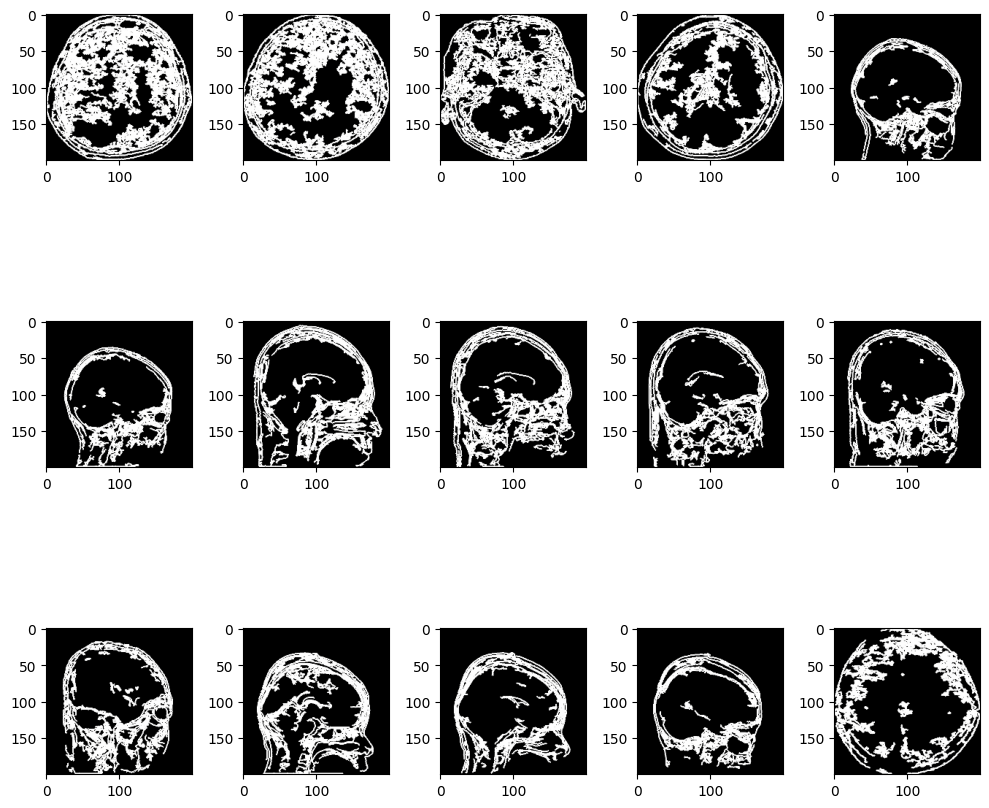

In [6]:
images = [x_train[i] for i in range(30)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [7]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1077, 200, 200, 3)


In [8]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [9]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(None, None, 3))

In [10]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.load_weights(r'C:\Users\Potat\Desktop\WorkSpace\DataScience\model-05-0.73-0.88.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [11]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rd logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run tensorBoard
%tensorboard --logdir logs

El directorio no est� vac�o.


Reusing TensorBoard on port 6006 (pid 21132), started 4 days, 1:15:59 ago. (Use '!kill 21132' to kill it.)

In [12]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 10

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history =  model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/9
216/216 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.7337
Epoch 1: val_loss improved from inf to 2.78063, saving model to model-01-0.38-2.78.h5
216/216 [==============================] - 1023s 5s/step - loss: 0.6687 - accuracy: 0.7337 - val_loss: 2.7806 - val_accuracy: 0.3779 - lr: 1.0000e-04
Epoch 2/9
216/216 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.8322
Epoch 2: val_loss did not improve from 2.78063
216/216 [==============================] - 999s 5s/step - loss: 0.4334 - accuracy: 0.8322 - val_loss: 2.8002 - val_accuracy: 0.3083 - lr: 1.0000e-04
Epoch 3/9
216/216 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8727
Epoch 3: val_loss improved from 2.78063 to 1.64846, saving model to model-03-0.55-1.65.h5
216/216 [==============================] - 995s 5s/step - loss: 0.3332 - accuracy: 0.8727 - val_loss: 1.6485 - val_accuracy: 0.5469 - lr: 1.0000e-04
Epoch 4/9
216/216 [=========================

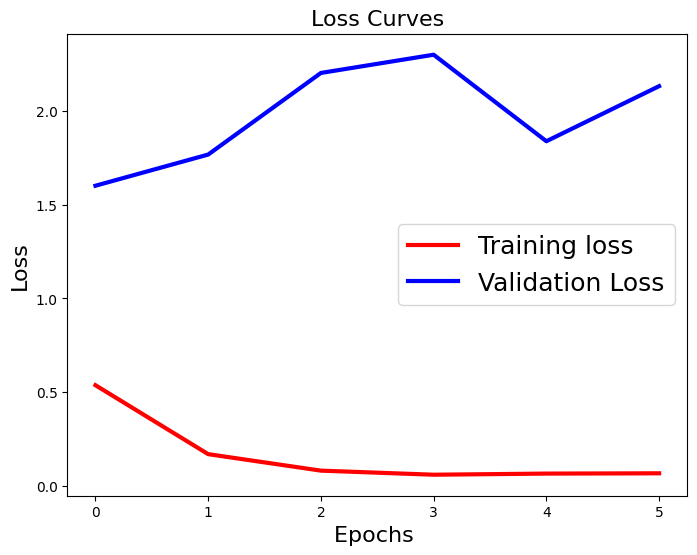

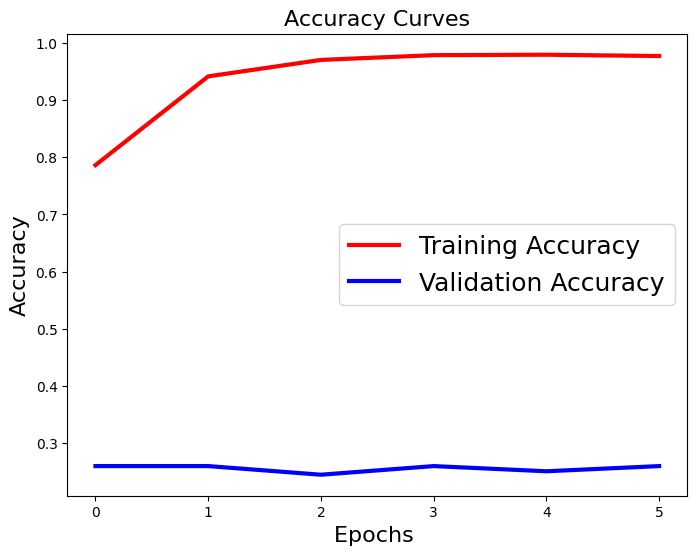

In [12]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

20/20 [==============================] - 30s 2s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.00      0.00      0.00       160
           2       0.28      1.00      0.44       178
           3       0.00      0.00      0.00       138

    accuracy                           0.28       630
   macro avg       0.07      0.25      0.11       630
weighted avg       0.08      0.28      0.12       630



c:\Users\Potat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Potat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Potat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

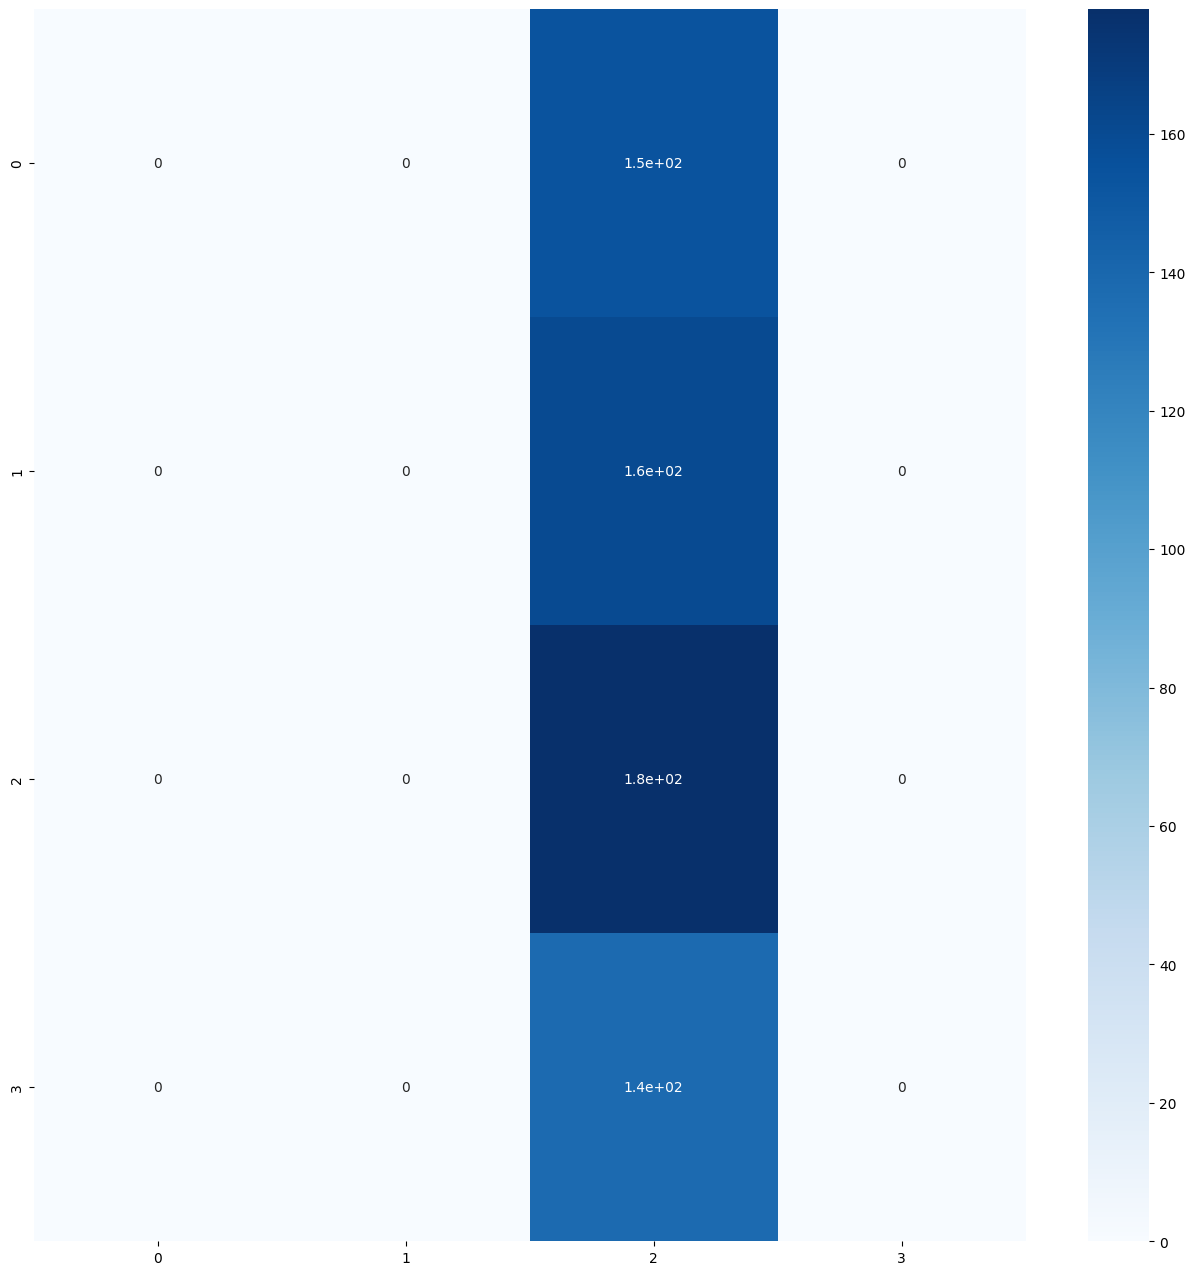

In [13]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [14]:
loss,acc = model.evaluate(x_test,y_test)

20/20 [==============================] - 30s 2s/step - loss: 1.6339 - accuracy: 0.2825


In [15]:
from glob import glob

mri_files = glob(r'C:\Users\Potat\Desktop\WorkSpace\DataScience\Imagenes_de_prueba\*.jpg')
print(mri_files)

def image_resize(img):

  scale_percent = 60 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized


['C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\glioma1.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\glioma2.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\glioma3.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\glioma4.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\meningioma1.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\meningioma2.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\meningioma3.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\notumor1.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\notumor2.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\notumor3.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\pituitary1.jpg', 'C:\\Users\\Potat\\Desktop\\WorkSpace\\DataScience\\dataset\\other\\pituitary2.

## Codigo de Crop de imagenes

In [16]:
img = cv2.imread(mri_files[0])
img = image_resize(img)
img= cv2.pyrDown(img)

# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Smoothing the image
blur = cv2.medianBlur(gray, 3) 
kernel =cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))

otsu_threshold, image_result = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)

dilate = cv2.dilate(image_result, None, iterations=2)
closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)

cannyImage = cv2.Canny(closing, threshold1=otsu_threshold, threshold2=255, edges=1)

# find contours in thresholded image, then grab the largest one
cnts ,_= cv2.findContours(cannyImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

biggest_cnt = sorted([(idx, cv2.contourArea(c)) for (idx, c) in enumerate(cnts)],key=lambda x: x[1] ,reverse=True)
print(biggest_cnt)

contour_list = []
for contour,area in biggest_cnt:
    approx = cv2.approxPolyDP(cnts[contour],0.01*cv2.arcLength(cnts[contour],True),True)
    #area = cv2.contourArea(contour)
    if ((len(approx) > 3) & (area > 100)):
        contour_list.append(cnts[contour])
        break

c = max(contour_list, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

[(3, 23.5), (1, 11.5), (2, 9.5), (0, 6.5)]


ValueError: max() arg is an empty sequence

In [ ]:
def drawborders(im):
  im = Image.fromarray(im)
  im = im.convert('RGB')
  arr = np.array(im)
  height = arr.shape[0]
  width = arr.shape[1]
  gray = cv2.cvtColor(arr,cv2.COLOR_BGR2GRAY)
  edged = cv2.Canny(gray, 30, 200)
  cv2.waitKey(0)

  contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.waitKey(0)
  print("Number of Contours found = " + str(len(contours)))
  arr2 = np.zeros((height,width,3), np.uint8)

  im_contour = cv2.drawContours(arr2, contours, -1, (255, 255, 255), 3)

  return arr2

C:\Users\Potat\Desktop\WorkSpace\DataScience\dataset\other\pituitary1.jpg


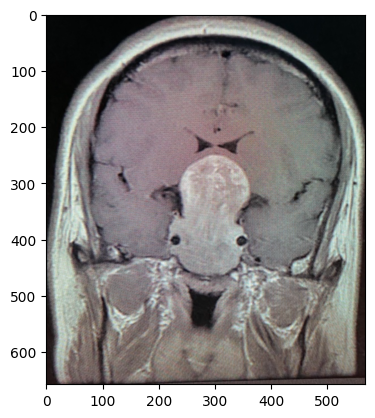

In [17]:
new_img = cv2.imread(mri_files[10])
print(mri_files[10])
# Imagen de bordes
new_img = drawborders(new_img)
plt.imshow(new_img)

## Codigo de Prediccion

1/1 [==============================] - 0s 494ms/step
[[0.00503227 0.12553193 0.8053559  0.06407997]] 

Congratulations🥳 there is no Tumor


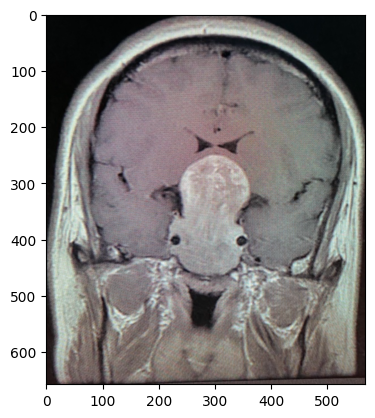

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = np.expand_dims(new_img, axis=0)

prediction = model.predict(image)
print(prediction,'\n')
predict_index = np.argmax(prediction)

if(predict_index==0):
    print("Oh no💀 there is a Glioma Tumor")  
elif(predict_index==1):
    print("Oh no🥵 there is a Meningioma Tumor")
elif(predict_index==2):
    print("Congratulations🥳 there is no Tumor")
elif(predict_index==3):
    print("Oh no🤑 there is a Pituitary Tumor")


plt.imshow(new_img)
plt.show()